In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy
import scipy.stats as st
import scipy.special
import pandas
import csv
import math
import multiprocessing as mp
import datetime
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive

## **Google Drive**

In [2]:
# connect to google drive to save the csv file
drive.mount('drive')
os.chdir("drive/My Drive/Yen-Ting Lin/Code")

Mounted at drive


## **Initial Parameters**

### **4SRA Parameters**

In [52]:
# define class to inital RA parameter
class init_RAparameter():
  # initail parameter for statistics value
  def __init__(self, config, sample, subcarrier_4sra, T_RAREP_4sra, T_RAR_4sra, W_RAR_4sra, W_BO_4sra, retrans_4sra):
    self.config = config
    self.sample = sample # number of simulation time
    self.nUE = 0 # num_UE[0] # number of UE
    self.subcarrier = subcarrier_4sra # number of preamble
    self.T_RAREP = T_RAREP_4sra
    self.T_RAR = T_RAR_4sra
    self.W_RAR = W_RAR_4sra
    self.W_BO = W_BO_4sra
    self.retrans = retrans_4sra
    # self.success_time = 0 # average access time
    self.MS = 0
    self.MS_FB = 0
    self.P_s = 0 # successful probability
    self.P_s_FB = 0 # successful probability
    # self.uti # utilization
    self.iteMiSn = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.iteMiFn = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.totalMis = [[0]*(maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans) + 1) for _ in range(0, self.sample)]
    self.iteMiSn_FB = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.iteMiFn_FB = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.totalMis_FB = [[0]*(maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans) + 1) for _ in range(0, self.sample)]
    self.Da = 0 # access delay
    self.Da_MiSn = 0
    self.Da_FB = 0
    self.Da_MiSn_FB = 0
  # initail parameter for each iteration
  def define_RAparameter(self):
    self.dict_retr = 0
    # initial dict_prea = {0:0, 1:0, ..., nUE:0}, UE index : preamble
    self.dict_prea = gen_UE_prea(self.nUE)
    # initial slot_lit = [[], [], [], ..., []], ue number in each slot
    self.slot_list = [[] for j in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans) + 1)]
    # initial dict_backoffcnt = {0:0, 1:0, ..., nUE:0}, UE index : backoff counter
    self.dict_backoffcnt = gen_UE_backoffcnt(self.nUE)
    # initial UE_list[UE_id][x]
    # x=0 arrive time, x=1 1st attempt time, x=2 2nd attemp time
    # x=3 3nd attemp time, x=4 4nd attempt time
    # x=5 RA status (0 = over max_transmit, 1 = successful, 2 = failed)
    # [slot = -1 (arrive time), slot = 1st attempt, slot = 2nd attempt, slot = 3nd attempt, slot = 4nd attempt, RA status)]
    self.UE_list = [[-1]*(self.retrans + 3) for _ in range(0, self.nUE)]
    # initail arrive_num from slot0 to Imax
    self.arrive_num = [0 for j in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    # to record which UE exceed max retransmission
    self.list_left = []
    # total number of fallback-UEs from 2SRA
    self.M_FB = 0
    self.avg_M_FB = 0
    # to record how many time of the process has passed
    self.slot_time = 0
    # to eliminate the gap of slot between 2SRA and 4SRA
    self.slot_offset = []
    # to indicate RA to stop the current process if = 1
    self.slot_stop = []
    # inital statistic value for each iteration
    self.MiSn = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.MiFn = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.MiSn_FB = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.MiFn_FB = [[0]*(self.retrans + 1) for _ in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
    self.T = [0 for j in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans))]
  def arrival_process(self, slot, dict_retr, dict_prea, dict_backoffcnt, UE_list, list_left, slot_time, T_RAREP, slot_offset, slot_stop):
    # one-shot
    if slot == 0 :
      # initial dict_retr = {0:0, 1:0, ..., nUE:0}, UE index : retransmission counter
      self.dict_retr = gen_UE_id(self.nUE)
      self.arrive_num[slot] = len(self.dict_retr)
      for i in range (0, self.nUE):
        self.dict_backoffcnt[i] = 1
    # here can process other arrival process, ex: Possion
    # here we add new arrival from 2SRA that UEs need to fallback to 4SRA
    else:
      # if the gap of slot between 2SRA and 4SRA is larger than one 2SRA slot
      # which means the next 2SRA slot will still in the current 4SRA slot
      # print(slot_time, self.slot_time, ((slot_time - self.slot_time) / self.T_RAREP))
      # print("arrivel", self.slot_time, slot_time)
      if (T_RAREP > self.T_RAREP) and ((slot_time - self.slot_time) / self.T_RAREP) >= 1.0:
        # print("4SRA slot gap occurs")
        # 2SRA and 4SRA have one 2SRA slot gap
        slot_offset.append(1)
        # print("4SRA slot offset", slot_offset)
        # to stop 4SRA process
        slot_stop.append(1)
      # if the current 2SRA slot is larger than current 4SRA slot
      # which means fallback UEs in the current 2SRA slot will need to fallback to next 4SRA slot
      elif (T_RAREP < self.T_RAREP) and self.slot_time > slot_time:
        # print("2SRA slot gap occurs")
        # 2SRA and 4SRA have one 4SRA slot gap
        self.slot_offset.append(1)
        # print("2SRA slot offset", slot_offset)
        # to stop 2SRA process
        self.slot_stop.append(1)
      # fallback UEs could just fallback to 2SRA, no need to wait
      else:
        # if there have some UEs left 2SRA
        if len(list_left) > 0:
          for i in range(0, len(list_left)):
            # add new key to dict_retr of 4SRA
            # used to be (list_left[i] + self.nUE) but it will cause index_error for UE_list
            # with len(UE_list), dict_retr will become {0:0, 1:0, ..., nUE:0, (nUE + 1):0}
            dict_retr[len(UE_list)] = 0
            dict_prea[len(UE_list)] = 0
            # so that UEs could transmit in the next slot directly after fallback
            dict_backoffcnt[len(UE_list)] = 0
            UE_list.append([-1, -1, -1, -1, -1, -1])
        # record how many UEs fallback from 2SRA
        # print("number of fallback UEs", len(list_left))
        self.M_FB += len(list_left)
        # remove all UEs from 2SRA list_left
        del list_left[:]
        # self.arrive_num[slot] = len(self.dict_retr)
        # case for T_RAREP_4sra > T_RAREP_2sra : to start 4SRA process
        del slot_stop[:]
        # case for T_RAREP_2sra > T_RAREP_4sra : to start 2SRA process
        del self.slot_stop[:]
      # print("slot_offset", slot_offset, "slot_stop", slot_stop)
  def departure_process(self, slot, countdown):
    for ue in list(self.dict_retr):
      self.dict_backoffcnt[ue] -= countdown
      # when backoff conunter equal to 0 means it's time to contend the RACH resource
      if self.dict_backoffcnt[ue] <= 0:
        # genearate preamble for each of ue, EX: dict_prea = {0:23, 1:34, ..., nUE:16}
        self.dict_prea[ue] = self.doRA()
        # append ue in slot_list to know which ue in current slot, EX: slot_list = [[0,1,2,...,nUE], [...], ..., [...]]
        self.slot_list[slot].append(ue)
        # record infomation in UE_list
        # print(ue, self.dict_retr[ue] + 1)
        self.UE_list[ue][self.dict_retr[ue] + 1] = slot
    # check the preamble to get the success ue and remove the success ue from dict_retr
    self.check_preamble(slot, self.subcarrier)
    # add retranmsission counter for failure ue in dict_retr
    self.doretrans(slot)
    # give the random backoff counter for the ue in dict_retr
    self.backoff(slot)
  # give preamble for each UE
  def doRA(self):
    if self.subcarrier != 0:
      return random.randint(1, self.subcarrier)
    else:
      return -1
  def check_preamble(self, slot, subcarrier):
    # check preamble from preamble 1 to subcarrier
    for preamble in range(1, int(subcarrier) + 1):
      # print("Preamble", preamble)
      # get which ue choose current preamble, EX: collided_ue = [1, 5, 23...]
      collided_ue = self.preak(slot, preamble)
      # make sure the collided_ue is larger than 0 that means at least one ue choose this premable and mark this ue is success
      if len(collided_ue) != 0:
        self.find_succuss_RA(slot, collided_ue)
  # check the preamble choosen by whihc UE
  def preak(self, slot, preamble):
    collided_ue = []
    # ue_list = slot_list[slot], ue_list is the UE in current slot
    for i in self.slot_list[slot]:
      # check each of UE's preamble (dict_prea) is equal to current preamble or not and record which ue is same as current preamble
      if self.dict_prea[i] == preamble:
        # put UE number that has selected that preamble
        collided_ue.append(i)
    return collided_ue
  # get non collision UE and remove from dict_retr
  def find_succuss_RA(self, slot, collided_ue):
    # non collision
    if len(collided_ue) == 1:
      # print("Successful UE ID", collided_ue)
      # success UE
      success_ue = collided_ue[0]
      # get the retransmsission counter
      retry = self.dict_retr[success_ue]
      # print(slot, retry)
      if success_ue < self.nUE:
        # add one success in MiSn (4SRA)
        self.MiSn[slot][retry] += 1
      else:
        # add one success in MiSn_FB (2SRA fallback)
        self.MiSn_FB[slot][retry] += 1
      # mark UE status as '1'
      self.UE_list[success_ue][5] = 1
      # remove success ue from dict_retr
      del self.dict_retr[success_ue]
    # more than one UE choose current preamble
    else:
      # print("Collided UE ID", collided_ue)
      # loop all the collision UE
      for failed_ue in collided_ue:
        # get the retransmsission counter
        retry = self.dict_retr[failed_ue]
        # print(slot, retry)
        if failed_ue < self.nUE:
          # add one fialure in MiFn (4SRA)
          self.MiFn[slot][retry] += 1
        else:
          # add one fialure in MiFn_FB (2SRA fallback)
          self.MiFn_FB[slot][retry] += 1
        # mark UE status as '0'
        self.UE_list[failed_ue][5] = 0
      success_ue = -1
  # add retranmsission counter for UE in dict_retr and current slot
  # delete UE from dict_retr if UE reach to maximum retransmission number
  def doretrans(self, slot):
    # retr_ue = slot_list[slot], retr_ue is UE in current slot
    for i in self.slot_list[slot]:
      if i in self.dict_retr:
        # add retransmission counter for failure UE
        self.dict_retr[i] += 1
        # mark UE status as '2'
        self.UE_list[i][5] = 2
        # check retransmission counter is larger than the max retranmsission times or not
        if self.dict_retr[i] > self.retrans:
          # mark UE status as '0'
          self.UE_list[i][5] = 0
          # exceed max retransmission times and remove this UE from dict_retr
          # record the UE id into list_left
          self.list_left.append(list(self.dict_retr.keys())[list(self.dict_retr.values()).index(4)])
          del self.dict_retr[i]
  # give the random backoff counter for the ue in dict_retr and current slot
  def backoff(self, slot):
    for i in self.slot_list[slot]:
      if i in self.dict_retr:
        retrans_slot = int(slot + np.ceil((self.T_RAR + self.W_RAR + random.uniform(0, self.W_BO)) / self.T_RAREP))
        self.dict_backoffcnt[i] = retrans_slot - slot
  def calculate_statistic(self):
    # accumulate MiSn, MiFn
    for temp_i in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans)):
      for temp_n in range (0, self.retrans + 1):
        self.iteMiSn[temp_i][temp_n] += self.MiSn[temp_i][temp_n]
        self.iteMiFn[temp_i][temp_n] += self.MiFn[temp_i][temp_n]
        self.iteMiSn_FB[temp_i][temp_n] += self.MiSn_FB[temp_i][temp_n]
        self.iteMiFn_FB[temp_i][temp_n] += self.MiFn_FB[temp_i][temp_n]
  def get_MS(self):
    for temp_i in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans)):
      # average total data size / accumulate data size in each slot
      for temp_n in range (0, self.retrans + 1):
        self.iteMiSn[temp_i][temp_n] = self.iteMiSn[temp_i][temp_n] / float(self.sample)
        self.iteMiFn[temp_i][temp_n] = self.iteMiFn[temp_i][temp_n] / float(self.sample)
        self.MS += self.iteMiSn[temp_i][temp_n]
        self.iteMiSn_FB[temp_i][temp_n] = self.iteMiSn_FB[temp_i][temp_n] / float(self.sample)
        self.iteMiFn_FB[temp_i][temp_n] = self.iteMiFn_FB[temp_i][temp_n] / float(self.sample)
        self.MS_FB += self.iteMiSn_FB[temp_i][temp_n]
    self.MS = round((self.MS) * 1000000) / 1000000
    self.MS_FB = round((self.MS_FB) * 1000000) / 1000000
  def report(self):
    self.get_MS()
    # sucesss probability
    if self.nUE != 0:
      self.P_s = round((float(self.MS) / float(self.nUE)) * 1000000) / 1000000
    else:
      self.P_s = 0.0
    if self.avg_M_FB != 0:
      self.P_s_FB = round((float(self.MS_FB) / float(self.avg_M_FB)) * 1000000) / 1000000
    else:
      self.P_s_FB = 0.0
    # utilization
    # if self.subcarrier != 0:
    #   self.uti = round((float(MS) / float(maxslot() * self.subcarrier)) * 1000000) / 1000000
    # else:
    #   self.uti = 0.0
    # access delay
    for temp_i in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans)):
      self.T[temp_i] = (temp_i + 1) * self.T_RAREP + self.T_RAR + self.W_RAR
      for temp_n in range (0, self.retrans + 1):
        self.Da_MiSn += self.iteMiSn[temp_i][temp_n] * float(self.T[temp_i])
    if self.nUE != 0 and self.MS != 0:
      self.Da = float(self.Da_MiSn) / float(self.MS)
    else:
      self.Da = 0.0
    for temp_i in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans)):
      self.T[temp_i] = (temp_i + 1) * self.T_RAREP + self.T_RAR + self.W_RAR
      for temp_n in range (0, self.retrans + 1):
        self.Da_MiSn_FB += self.iteMiSn_FB[temp_i][temp_n] * float(self.T[temp_i])
    if self.avg_M_FB != 0 and self.MS_FB != 0:
      self.Da_FB = float(self.Da_MiSn_FB) / float(self.MS_FB)
    else:
      self.Da_FB = 0.0

### **2SRA Parameters**

In [53]:
# define class to inital 2SRA parameter
class init_2SRAparameter(init_RAparameter):
  # initail parameter for statistics value
  def __init__(self, config, sample, subcarrier_4sra, subcarrier_2sra,
               T_RAREP_4sra, T_RAREP_2sra,
               T_RAR_4sra, T_RAR_2sra,
               W_RAR_4sra, W_RAR_2sra,
               W_BO_4sra, W_BO_2sra,
               retrans_4sra, retrans_2sra):
    # inherit the parameter initialisation from RA
    # so that we can use the same initial parameters
    super().__init__(config, sample, subcarrier_2sra, T_RAREP_2sra, T_RAR_2sra, W_RAR_2sra, W_BO_2sra, retrans_2sra)
    self.four_SRA = init_RAparameter("4SRA", sample, subcarrier_4sra, T_RAREP_4sra, T_RAR_4sra, W_RAR_4sra, W_BO_4sra, retrans_4sra)
    self.P_s_T = 0 # total successful probability
    self.Ms_T = 0 # total number of successful UE
    self.Uti_T = 0 # total number of resource been used
    self.Da_T = 0 # total access delay
  # initail parameter for each iteration
  def define_RAparameter(self):
    # initail parameter for different procedure
    self.nUE = num_UE_2SRA[0]
    super().define_RAparameter()
    self.four_SRA.nUE = num_UE - num_UE_2SRA[0]
    self.four_SRA.define_RAparameter()
  def arrival_process(self, slot, dict_retr, dict_prea, dict_backoffcnt, UE_list, list_left, slot_time, T_RAREP, slot_offset, slot_stop):
    super().arrival_process(slot, dict_retr, dict_prea, dict_backoffcnt, UE_list, list_left, slot_time, T_RAREP, slot_offset, slot_stop)
    self.four_SRA.arrival_process(slot, 0, 0, 0, [], [], 0, 0, [], [])
  def departure_process(self, slot, countdown):
    super().departure_process(slot, countdown)
  def calculate_statistic(self):
    super().calculate_statistic()
    self.four_SRA.calculate_statistic()
  def get_MS(self):
    super().get_MS()
  def report(self):
    # calculat the average ue number for 4SRA UE and 2SRA UE
    self.four_SRA.report()
    self.report_2SRA()
    self.calculate_total()
  def report_2SRA(self):
    self.get_MS()
    # sucesss probability
    if self.nUE != 0:
      self.P_s = round((float(self.MS) / float(self.nUE)) * 1000000) / 1000000
    else:
      self.P_s = 0.0
    # utilization
    # if self.subcarrier != 0:
    #   self.uti = round((float(MS) / float(maxslot() * self.subcarrier)) * 1000000) / 1000000
    # else:
    #   self.uti = 0.0
    # access delay
    for temp_i in range(0, maxslot(self.T_RAREP, self.T_RAR, self.W_RAR, self.W_BO, self.retrans)):
      self.T[temp_i] = (temp_i + 1) * self.T_RAREP + self.T_RAR + self.W_RAR
      for temp_n in range (0, self.retrans + 1):
        self.Da_MiSn += self.iteMiSn[temp_i][temp_n] * float(self.T[temp_i])
    if self.nUE != 0 and self.MS != 0:
      self.Da = float(self.Da_MiSn) / float(self.MS)
    else:
      self.Da = 0.0
  # calcualte the Ms_T, P_s_T, Da_T, Uti_T
  def calculate_total(self):
    # total successful UE
    self.Ms_T = float(self.MS) + float(self.four_SRA.MS) + float(self.four_SRA.MS_FB)
    # total sucesss probability
    if self.nUE != 0 or self.four_SRA.nUE != 0 or self.four_SRA.MS_FB != 0:
      self.P_s_T = round(((self.Ms_T) / (float(self.nUE) + float(self.four_SRA.nUE))) * 1000000) / 1000000
    else:
      self.P_s_T = 0.0
    # total utilization
    # if self.subcarrier != 0 or self.four_SRA.subcarrier != 0:
    #   self.Uti_T = round(((float(self.MS) + float(self.four_SRA.MS)) / (float(maxslot() * (self.subcarrier + self.four_SRA.subcarrier)))) * 1000000) / 1000000
    # else:
    #   self.Uti_T = 0.0
    # total access delay
    if (self.MS + self.four_SRA.MS + self.four_SRA.MS_FB) != 0:
      self.Da_T = round((self.Da * float(self.MS) + self.four_SRA.Da * float(self.four_SRA.MS) + self.four_SRA.Da_FB * float(self.four_SRA.MS_FB)) / (float(self.MS) + float(self.four_SRA.MS) + float(self.four_SRA.MS_FB)) * 1000000) / 1000000
    else:
      self.Da_T = 0.0

## **Initial Functions**

In [54]:
# Give UE id for each UE
# dict_id = {0:0, 1:0, ..., nUE:0}
def gen_UE_id(num_UE):
  seq = [i for i in range(0, num_UE)]
  dict_id = dict.fromkeys(seq, 0)
  return dict_id

# Initial dict_prea list and get the preamble of each of UE##
# dict_prea = {0:0, 1:0, ..., nUE:0}, UE index : preamble
def gen_UE_prea(num_UE):
  dict_prea = {}
  for i in range(0, num_UE):
    dict_prea[i] = 0
  return dict_prea

# Initial backoff counter for each of UE
# dict_backoffcnt = {0:0, 1:0, ..., nUE:0}, UE index : backoff counter
def gen_UE_backoffcnt(num_UE):
  dict_backoffcnt = {}
  for i in range(0, num_UE):
    dict_backoffcnt[i] = 0
  return dict_backoffcnt

# Calculate the maximum slot
def maxslot(T_RAREP, T_RAR, W_RAR, W_BO, retrans):
  Maxraslot = np.ceil((T_RAR + W_RAR + W_BO) / T_RAREP) * (retrans + 1) + 1
  return int(Maxraslot) + 100
  # Maxraslot = np.ceil(((np.ceil((T_RAR + W_RAR + W_BO) / T_RAREP) * (retrans + 1) + 1) - T_RAREP) / T_RAREP) + np.ceil((T_RAR + W_RAR + W_BO) / T_RAREP) * (retrans + 1) + 1
  # return int(Maxraslot)

## **Arrival Process**

In [ ]:
def arrival_process(self, slot):
  # one-shot
  if slot == 0 :
    # initial dict_retr = {0:0, 1:0, ..., nUE:0}, UE index : retransmission counter
    self.dict_retr = gen_UE_id(self.nUE)
    self.arrive_num[slot] = len(self.dict_retr)
    for i in range (0, self.nUE):
      self.dict_backoffcnt[i] = 1
  # here can process other arrival process, ex: Possion
  else:
    self.arrive_num[slot] = len(self.dict_retr)

## **Departure Process**

In [ ]:
def departure_process(self, slot, countdown):
  for ue in list(self.dict_retr):
    self.dict_backoffcnt[ue] -= countdown
    # when backoff conunter equal to 0 means it's time to contend the RACH resource
    if self.dict_backoffcnt[ue] <= 0:
      # genearate preamble for each of ue, EX: dict_prea = {0:23, 1:34, ..., nUE:16}
      self.dict_prea[ue] = doRA(self.subcarrier)
      # append ue in slot_list to know which ue in current slot, EX: slot_list = [[0,1,2,...,nUE], [...], ..., [...]]
      self.slot_list[slot].append(ue)
      # record infomation in UE_list
      self.UE_list[ue][self.dict_retr[ue] + 1] = slot
  # check the preamble to get the success ue and remove the success ue from dict_retr
  self.check_preamble(slot, self.subcarrier)
  # add retranmsission counter for failure ue in dict_retr
  doretrans(self.dict_retr, self.slot_list[slot], self.UE_list)
  # give the random backoff counter for the ue in dict_retr
  backoff(self.dict_retr, self.dict_backoffcnt, self.slot_list, slot)

### **Preamble Selection**

In [ ]:
# give preamble for each UE
def doRA(subcarrier):
  if subcarrier != 0:
    return random.randint(1, subcarrier)
  else:
    return -1

### **Preamble Checking**

In [ ]:
def check_preamble(self, slot, subcarrier):
  # check preamble from preamble 1 to subcarrier
  for preamble in range(1, int(subcarrier) + 1):
    # get which ue choose current preamble, EX: collided_ue = [1, 5, 23...]
    collided_ue = preak(self.dict_prea, self.slot_list[slot], preamble)
    # make sure the collided_ue is larger than 0 that means at least one ue choose this premable and mark this ue is success
    if len(collided_ue) != 0:
      find_succuss_RA(self, slot, collided_ue)

# check the preamble choosen by whihc UE
def preak(dict_prea, ue_list, preamble):
  collided_ue = []
  # ue_list = slot_list[slot], ue_list is the UE in current slot
  for i in ue_list:
    # check each of UE's preamble (dict_prea) is equal to current preamble or not and record which ue is same as current preamble
    if dict_prea[i] == preamble:
      # put UE number that has selected that preamble
      collided_ue.append(i)
  return collided_ue

# get non collision UE and remove from dict_retr
def find_succuss_RA(self, slot, collided_ue):
  # non collision
  if len(collided_ue) == 1:
    # success UE
    success_ue = collided_ue[0]
    # get the retransmsission counter
    retry = self.dict_retr[success_ue]
    # add one success in MiSn
    self.MiSn[slot][retry] += 1
    # mark UE status as '1'
    self.UE_list[success_ue][5] = 1
    # remove success ue from dict_retr
    del self.dict_retr[success_ue]
  # more than one UE choose current preamble
  else:
    # loop all the collision UE
    for failed_ue in collided_ue:
      # get the retransmsission counter
      retry = self.dict_retr[failed_ue]
      # add one fialure in MiFn
      self.MiFn[slot][retry] += 1
      # mark UE status as '0'
      self.UE_list[failed_ue][5] = 0
    success_ue = -1

### **Retransmission**

In [ ]:
# add retranmsission counter for UE in dict_retr and current slot
# delete UE from dict_retr if UE reach to maximum retransmission number
def doretrans(dict_retr, retr_ue, UE_list, retrans):
  # retr_ue = slot_list[slot], retr_ue is UE in current slot
  for i in retr_ue:
    if i in dict_retr:
      # add retransmission counter for failure UE
      dict_retr[i] += 1
      # mark UE status as '2'
      UE_list[i][5] = 2
      # check retransmission counter is larger than the max retranmsission times or not
      if dict_retr[i] > retrans:
        # mark UE status as '0'
        UE_list[i][5] = 0
        # exceed max retransmission times and remove this UE from dict_retr
        del dict_retr[i]

### **Back-off Assignment**

In [ ]:
# give the random backoff counter for the ue in dict_retr and current slot
def backoff(dict_retr, dict_backoffcnt, slot_list, slot):
  for i in slot_list[slot]:
    if i in dict_retr:
      retrans_slot = int(slot + np.ceil((T_RAR + W_RAR + random.uniform(0, W_BO)) / T_RAREP))
      dict_backoffcnt[i] = retrans_slot - slot

## **Statistic Calculation and Report**

In [ ]:
# calculate the average MiSn, MiFn, N_RU, and attempUE for each of iteration
def calculate_statistic(self, retrans):
  # accumulate MiSn, MiFn, N_RU
  for temp_i in range(0, maxslot()):
    for temp_n in range (0, retrans + 1):
      self.iteMiSn[temp_i][temp_n] += self.MiSn[temp_i][temp_n]
      self.iteMiFn[temp_i][temp_n] += self.MiFn[temp_i][temp_n]

In [ ]:
# calculate the MS for calculating the performance matrix
def get_MS(self, retrans):
  self.MS = 0
  for temp_i in range(0, maxslot()):
    # average total data size / accumulate data size in each slot
    for temp_n in range (0, retrans + 1):
      self.iteMiSn[temp_i][temp_n] = self.iteMiSn[temp_i][temp_n] / float(self.sample)
      self.iteMiFn[temp_i][temp_n] = self.iteMiFn[temp_i][temp_n] / float(self.sample)
      self.MS += self.iteMiSn[temp_i][temp_n]
  self.MS = round((self.MS) * 1000000) / 1000000

In [ ]:
# calculate the performance matrix
# Ps, T_DATA, utilization, Da, Dd, CDF of prea_trans, CDF of Da
def report(self, retrans):
  self.get_MS(retrans)
  # sucesss probability
  if self.nUE != 0:
    self.P_s = round((float(self.MS) / float(self.nUE)) * 1000000) / 1000000
  else:
    self.P_s = 0.0
  # utilization
  # if self.subcarrier != 0:
  #   self.uti = round((float(MS) / float(maxslot() * self.subcarrier)) * 1000000) / 1000000
  # else:
  #   self.uti = 0.0
  # access delay
  for temp_i in range(0, maxslot()):
    self.T[temp_i] = (temp_i + 1) * T_RAREP + T_RAR + W_RAR
    for temp_n in range (0, retrans + 1):
      self.Da_MiSn += self.iteMiSn[temp_i][temp_n] * float(self.T[temp_i])
  if self.nUE != 0 and self.MS != 0:
    self.Da = float(self.Da_MiSn) / float(self.MS)
  else:
    self.Da = 0.0

## **Main Function**

In [55]:
def main(sample, subcarrier_4sra, subcarrier_2sra,
         T_RAREP_4sra, T_RAREP_2sra,
         T_RAR_4sra, T_RAR_2sra,
         W_RAR_4sra, W_RAR_2sra,
         W_BO_4sra, W_BO_2sra,
         retrans_4sra, retrans_2sra):
  cobject = init_2SRAparameter("2SRA", sample, subcarrier_4sra, subcarrier_2sra,
                               T_RAREP_4sra, T_RAREP_2sra,
                               T_RAR_4sra, T_RAR_2sra,
                               W_RAR_4sra, W_RAR_2sra,
                               W_BO_4sra, W_BO_2sra,
                               retrans_4sra, retrans_2sra)
  iteM_FB = [0 for i in range(0, sample)]
  # sample loop
  for ite in range(0, cobject.sample):
    # initail parameter
    cobject.define_RAparameter()
    # slot loop
    for slot in range(0, len(cobject.slot_list)):
      # print("slot", slot)
      '''
      print("2SRA")
      print("retransmission counter\n", cobject.dict_retr)
      print("left UE\n", cobject.list_left)
      print("preamble for each of ue\n", cobject.dict_prea)
      print("backoff for each of ue\n", cobject.dict_backoffcnt)
      print("record of ue\n", cobject.UE_list)
      print("--------------------------------------")
      '''
      '''
      print("4SRA")
      print("retransmission counter\n", cobject.four_SRA.dict_retr)
      print("left UE\n", cobject.four_SRA.list_left)
      # print("preamble for each of ue\n", cobject.four_SRA.dict_prea)
      # print("backoff for each of ue\n", cobject.four_SRA.dict_backoffcnt)
      # print("number of successful ue\n", cobject.four_SRA.MiSn)
      print("record of ue\n", cobject.four_SRA.UE_list)
      print("--------------------------------------")
      '''

      # arrival process
      cobject.arrival_process(slot,
                     cobject.four_SRA.dict_retr,
                     cobject.four_SRA.dict_prea,
                     cobject.four_SRA.dict_backoffcnt,
                     cobject.four_SRA.UE_list,
                     cobject.list_left,
                     cobject.four_SRA.slot_time,
                     cobject.four_SRA.T_RAREP,
                     cobject.four_SRA.slot_offset,
                     cobject.four_SRA.slot_stop)
      # print("slot_offset", cobject.four_SRA.slot_offset, "slot_stop", cobject.four_SRA.slot_stop)
      '''
      print("After_Arrival_2SRA")
      print("retransmission counter\n", cobject.dict_retr)
      print("left UE\n", cobject.list_left)
      # print("preamble for each of ue\n", cobject.dict_prea)
      # print("backoff for each of ue\n", cobject.dict_backoffcnt)
      print("record of ue\n", cobject.UE_list)
      print("--------------------------------------")
      '''
      '''
      print("After_Arrival_4SRA")
      print("retransmission counter\n", cobject.four_SRA.dict_retr)
      print("left UE\n", cobject.four_SRA.list_left)
      # print("preamble for each of ue\n", cobject.four_SRA.dict_prea)
      # print("backoff for each of ue\n", cobject.four_SRA.dict_backoffcnt)
      # print("number of successful ue\n", cobject.four_SRA.MiSn)
      print("record of ue\n", cobject.four_SRA.UE_list)
      print("--------------------------------------")
      '''

      # departure process
      # use "or", if use "and", once one of these RAP finishes, both RAP will finish
      # if len(cobject.dict_retr) > 0 or len(cobject.four_SRA.dict_retr) > 0:
      #   cobject.departure_process(slot, 1)
      # else:
      #   break
      if cobject.T_RAREP < cobject.four_SRA.T_RAREP:
        if len(cobject.four_SRA.dict_retr) > 0 or len(cobject.dict_retr) > 0:
          if len(cobject.dict_retr) > 0:
            cobject.departure_process(slot, 1)
          if len(cobject.four_SRA.dict_retr) > 0:
            if len(cobject.four_SRA.slot_stop) <= 0:
              # print("4SRA slot start")
              cobject.four_SRA.departure_process(slot - len(cobject.four_SRA.slot_offset), 1)
            # else:
            #   print("4SRA slot stop")
        else:
          break
      elif cobject.T_RAREP > cobject.four_SRA.T_RAREP:
        if len(cobject.four_SRA.dict_retr) > 0 or len(cobject.dict_retr) > 0:
          if len(cobject.dict_retr) > 0:
            if len(cobject.slot_stop) <= 0:
              # print("2SRA slot start")
              cobject.departure_process(slot - len(cobject.slot_offset), 1)
            # else:
            #   print("2SRA slot stop")
          if len(cobject.four_SRA.dict_retr) > 0:
            cobject.four_SRA.departure_process(slot, 1)
        else:
          break
      elif cobject.T_RAREP == cobject.four_SRA.T_RAREP:
        if len(cobject.four_SRA.dict_retr) > 0 or len(cobject.dict_retr) > 0:
          cobject.departure_process(slot, 1)
          cobject.four_SRA.departure_process(slot, 1)
        else:
          break

      '''
      print("After_Departure_2SRA")
      print("retransmission counter\n", cobject.dict_retr)
      print("left UE\n", cobject.list_left)
      # print("preamble for each of ue\n", cobject.dict_prea)
      # print("backoff for each of ue\n", cobject.dict_backoffcnt)
      print("record of ue\n", cobject.UE_list)
      print("--------------------------------------")
      '''
      '''
      print("After_Departure_4SRA")
      print("retransmission counter\n", cobject.four_SRA.dict_retr)
      print("left UE\n", cobject.four_SRA.list_left)
      # print("preamble for each of ue\n", cobject.four_SRA.dict_prea)
      # print("backoff for each of ue\n", cobject.four_SRA.dict_backoffcnt)
      # print("number of successful ue\n", cobject.four_SRA.MiSn)
      print("record of ue\n", cobject.four_SRA.UE_list)
      print("======================================")
      '''

      if cobject.T_RAREP < cobject.four_SRA.T_RAREP:
        # if there's no gap between 2SRA nad 4SRA
        if ((cobject.four_SRA.slot_time - cobject.slot_time) / cobject.T_RAREP) < 1.0:
          # we don't stop 4SRA process at the current slot
          cobject.four_SRA.slot_time += cobject.four_SRA.T_RAREP
        # remember that we add slot_time of 4SRA first, then slot_time of 2SRA
        cobject.slot_time += cobject.T_RAREP
        # print("2 < 4", cobject.slot_time, cobject.four_SRA.slot_time)
      elif cobject.T_RAREP > cobject.four_SRA.T_RAREP:
        # if there's no gap between 2SRA nad 4SRA
        if cobject.slot_time <= cobject.four_SRA.slot_time:
          # we don't stop 2SRA process at the current slot
          cobject.slot_time += cobject.T_RAREP
        # remember that we add slot_time of 2SRA first, then slot_time of 4SRA
        cobject.four_SRA.slot_time += cobject.four_SRA.T_RAREP
        # print("2 > 4", cobject.slot_time, cobject.four_SRA.slot_time)
      # print("======================================")

      # accumulate statistic value from slot 0 to Imax
    # update total fallback-UEs from init_2SRAparameter to init_RAparameter
    # print("fallback ue\n", cobject.M_FB)
    iteM_FB[ite] = cobject.M_FB
    cobject.four_SRA.M_FB = cobject.M_FB
    cobject.calculate_statistic()
  # return vaule (success probability, ...etc)
  if cobject.nUE >= 0:
    cobject.avg_M_FB = round(float(sum(iteM_FB)) / float(cobject.sample) * 1000000) / 1000000
    cobject.four_SRA.avg_M_FB = cobject.avg_M_FB
    # print("average fallback ue\n", cobject.four_SRA.avg_M_FB)
    cobject.report()
    return cobject.four_SRA.nUE, cobject.four_SRA.MS, cobject.four_SRA.P_s, cobject.four_SRA.Da, cobject.nUE, cobject.MS, cobject.P_s, cobject.Da, cobject.four_SRA.avg_M_FB, cobject.four_SRA.MS_FB, cobject.four_SRA.P_s_FB, cobject.four_SRA.Da_FB, cobject.Ms_T, cobject.P_s_T, cobject.Da_T
  else:
    return -1

## **Multi-process Function**

In [56]:
# Multi process function
def test_process(sample, subcarrier_4sra, subcarrier_2sra,
                 T_RAREP_4sra, T_RAREP_2sra,
                 T_RAR_4sra, T_RAR_2sra,
                 W_RAR_4sra, W_RAR_2sra,
                 W_BO_4sra, W_BO_2sra,
                 retrans_4sra, retrans_2sra, lock):
  UE_4SR_list = [] # cobject.four_SRA.nUE
  MS_4SR_list = [] # cobject.four_SRA.MS
  Ps_4SR_list = [] # cobject.four_SRA.P_s
  Da_4SR_list = [] # cobject.four_SRA.Da

  UE_2SR_list = [] # cobject.nUE
  MS_2SR_list = [] # cobject.MS
  Ps_2SR_list = [] # cobject.P_s
  Da_2SR_list = [] # cobject.Da

  M_FB_list = [] # cobject.four_SRA.avg_M_FB
  MS_FB_list = [] # cobject.four_SRA.MS_FB
  Ps_FB_list = [] # cobject.four_SRA.P_s_FB
  Da_FB_list = [] # cobject.four_SRA.Da_FB

  MS_T_list = [] # cobject.Ms_T
  Ps_T_list = [] # cobject..P_s_T
  Da_T_list = [] # cobject.Da_T

  columns = ["M_4SRA", "N_4SRA", "Ms_4SRA", "Ps_4SRA", "Da_4SRA",
             "M_2SRA", "N_2SRA", "Ms_2SRA", "Ps_2SRA", "Da_2SRA",
             "M_FB", "Ms_FB", "Ps_FB", "Da_FB",
             "Ms_T", "Ps_T", "Da_T"]
  N_4SRA_list = [subcarrier_4sra[0] for i in range(0, len(num_UE_2SRA))]
  N_2SRA_list = [subcarrier_2sra[0] for i in range(0, len(num_UE_2SRA))]

  for ue in num_UE_2SRA[:]:
    print("Number of 2SRA UE : ", ue)
    avg_UE_4sra, MS_4sra, Ps_4sra, Da_4sra, avg_UE_2sra, MS_2sra, Ps_2sra, Da_2sra, M_FB, MS_FB, Ps_FB, Da_FB, MS_total, Ps_total, Da_total = main(sample,
                                                              subcarrier_4sra[0], subcarrier_2sra[0],
                                                              T_RAREP_4sra, T_RAREP_2sra,
                                                              T_RAR_4sra, T_RAR_2sra,
                                                              W_RAR_4sra, W_RAR_2sra,
                                                              W_BO_4sra, W_BO_2sra,
                                                              retrans_4sra, retrans_2sra)
    num_UE_2SRA.remove(ue)

    UE_4SR_list.append(avg_UE_4sra)
    MS_4SR_list.append(MS_4sra)
    Ps_4SR_list.append(Ps_4sra)
    Da_4SR_list.append(Da_4sra)

    UE_2SR_list.append(avg_UE_2sra)
    MS_2SR_list.append(MS_2sra)
    Ps_2SR_list.append(Ps_2sra)
    Da_2SR_list.append(Da_2sra)

    M_FB_list.append(M_FB)
    MS_FB_list.append(MS_FB)
    Ps_FB_list.append(Ps_FB)
    Da_FB_list.append(Da_FB)

    MS_T_list.append(MS_total)
    Ps_T_list.append(Ps_total)
    Da_T_list.append(Da_total)

  data = {"M_4SRA": UE_4SR_list, "N_4SRA" : N_4SRA_list, "Ms_4SRA": MS_4SR_list, "Ps_4SRA": Ps_4SR_list, "Da_4SRA": Da_4SR_list,
          "M_2SRA": UE_2SR_list, "N_2SRA" : N_2SRA_list, "Ms_2SRA": MS_2SR_list, "Ps_2SRA": Ps_2SR_list, "Da_2SRA": Da_2SR_list,
          "M_FB": M_FB_list, "Ms_FB": MS_FB_list, "Ps_FB": Ps_FB_list, "Da_FB": Da_FB_list,
          "Ms_T": MS_T_list, "Ps_T": Ps_T_list, "Da_T": Da_T_list}
  result = pandas.DataFrame(data)
  lock.acquire()
  # cvs_pandas = result.to_csv("sim_testresult.csv", mode='a', index=False, header=True, columns=columns)
  cvs_pandas = result.to_csv("sim_testresult.csv", mode='w+', index=False, header=True, columns=columns)
  lock.release()

## **Test Result**

In [57]:
# number of times of simulation
sample = 1000 # 1 for testing
# total number of UE
num_UE = 1000 # 40 for testing

# initail number of 2SRA UE
num_UE_2SRA = [1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90,
               100, 200, 300, 400, 500, 600, 700, 800, 900,
               910, 920, 930, 940, 950, 960, 970, 980, 990,
               991, 992, 993, 994, 995, 996, 997, 998, 999] # [20] for testing
'''
num_UE_2SRA = [999] # [20] for testing
'''

# for i in range(1, 101):
#   num_UE_2SRA.append(i * 10)

# number of preamble (total = 54)
subcarrier_4sra = [44] # [7] for testing
subcarrier_2sra = [10] # [3] for testing

# number of max retransmission
retrans_4sra = 3 # N_PTmax - 1
retrans_2sra = 3

# latency from MSG1 to MSG4
T_RAREP_4sra = 1280
T_RAR_4sra = 7 + 3
W_RAR_4sra = 16
W_BO_4sra = 4096

# latency from MSGA to MSGB
T_RAREP_2sra = 1780
T_RAR_2sra = 7 + 3
W_RAR_2sra = 16
W_BO_2sra = 4096

lock = mp.Lock()

if __name__=='__main__':
  starttime = datetime.datetime.now()
  print('starttime:', starttime)

  mprocess = mp.Process(target=test_process, args=(sample, subcarrier_4sra, subcarrier_2sra,
                                T_RAREP_4sra, T_RAREP_2sra,
                                T_RAR_4sra, T_RAR_2sra,
                                W_RAR_4sra, W_RAR_2sra,
                                W_BO_4sra, W_BO_2sra,
                                retrans_4sra, retrans_2sra, lock))
  mprocess.start()
  mprocess.join()

  endtime = datetime.datetime.now()
  print('endtime:', endtime)

  print('total:', endtime - starttime)

starttime: 2023-09-13 15:25:48.933403
Number of 2SRA UE :  1
Number of 2SRA UE :  2
Number of 2SRA UE :  3
Number of 2SRA UE :  4
Number of 2SRA UE :  5
Number of 2SRA UE :  6
Number of 2SRA UE :  7
Number of 2SRA UE :  8
Number of 2SRA UE :  9
Number of 2SRA UE :  10
Number of 2SRA UE :  20
Number of 2SRA UE :  30
Number of 2SRA UE :  40
Number of 2SRA UE :  50
Number of 2SRA UE :  60
Number of 2SRA UE :  70
Number of 2SRA UE :  80
Number of 2SRA UE :  90
Number of 2SRA UE :  100
Number of 2SRA UE :  200
Number of 2SRA UE :  300
Number of 2SRA UE :  400
Number of 2SRA UE :  500
Number of 2SRA UE :  600
Number of 2SRA UE :  700
Number of 2SRA UE :  800
Number of 2SRA UE :  900
Number of 2SRA UE :  910
Number of 2SRA UE :  920
Number of 2SRA UE :  930
Number of 2SRA UE :  940
Number of 2SRA UE :  950
Number of 2SRA UE :  960
Number of 2SRA UE :  970
Number of 2SRA UE :  980
Number of 2SRA UE :  990
Number of 2SRA UE :  991
Number of 2SRA UE :  992
Number of 2SRA UE :  993
Number of 2SRA

## **Plotting Figures**

In [58]:
sim = pandas.read_csv('sim_testresult.csv')
sim

,M_4SRA,N_4SRA,Ms_4SRA,Ps_4SRA,Da_4SRA,M_2SRA,N_2SRA,Ms_2SRA,Ps_2SRA,Da_2SRA,M_FB,Ms_FB,Ps_FB,Da_FB,Ms_T,Ps_T,Da_T
0,999,44,37.637,0.037675,13303.385551,1,10,1.000,1.000000,1806.000000,0.000,0.000,0.000000,0.000000,38.637,0.038637,13005.811062
1,998,44,37.601,0.037676,13297.544906,2,10,2.000,1.000000,2134.410000,0.000,0.000,0.000000,0.000000,39.601,0.039601,12733.764450
2,997,44,37.745,0.037859,13301.646576,3,10,3.000,1.000000,2386.873333,0.000,0.000,0.000000,0.000000,40.745,0.040745,12498.006381
3,996,44,37.844,0.037996,13308.891872,4,10,4.000,1.000000,2645.715000,0.000,0.000,0.000000,0.000000,41.844,0.041844,12289.565147
4,995,44,37.792,0.037982,13293.265030,5,10,5.000,1.000000,2931.672000,0.000,0.000,0.000000,0.000000,42.792,0.042792,12082.572256
5,994,44,37.692,0.037920,13281.362411,6,10,5.998,0.999667,3136.400133,0.002,0.002,1.000000,13466.000000,43.692,0.043692,11888.679209
6,993,44,37.584,0.037849,13306.544913,7,10,6.998,0.999714,3370.812804,0.002,0.002,1.000000,14106.000000,44.584,0.044584,11747.047012
7,992,44,37.699,0.038003,13294.689355,8,10,7.996,0.999500,3572.643322,0.004,0.004,1.000000,16026.000000,45.699,0.045699,11593.852251
8,991,44,37.630,0.037972,13288.541589,9,10,8.992,0.999111,3868.677936,0.008,0.007,0.875000,16117.428571,46.629,0.046629,11472.426902
9,990,44,37.788,0.038170,13303.036096,10,10,9.981,0.998100,4085.527101,0.019,0.019,1.000000,15453.368421,47.788,0.047788,11378.722441


In [59]:
ana = pandas.read_csv('ana_testresult.csv')
ana

,M_4SRA,N_4SRA,Ms_4SRA,Ps_4SRA,Da_4SRA,M_2SRA,N_2SRA,Ms_2SRA,Ps_2SRA,Da_2SRA,M_FB,Ms_FB,Ps_FB,Da_FB,Ms_T,Ps_T,Da_T
0,999,44,37.602585,0.037640,13299.034524,1,10,1.000000,1.000000,2095.912333,1.683900e-10,0.000000,0.000000,0.000000,38.602585,0.038603,13008.817633
1,998,44,37.619887,0.037695,13297.001846,2,10,2.000000,1.000000,2364.565490,3.780228e-08,0.000000,0.000000,0.000000,39.619887,0.039620,12745.135741
2,997,44,37.637231,0.037750,13294.963699,3,10,2.999999,1.000000,2617.817852,8.774391e-07,0.000001,1.139680,12636.433489,40.637231,0.040637,12506.735104
3,996,44,37.654616,0.037806,13292.919741,4,10,3.999992,0.999998,2860.387256,8.111779e-06,0.000008,0.986220,14660.325061,41.654616,0.041655,12291.109149
4,995,44,37.672033,0.037861,13290.870074,5,10,4.999955,0.999991,3095.708411,4.534267e-05,0.000043,0.948334,15307.749876,42.672031,0.042672,12096.287543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,5,44,4.999741,0.999948,1600.799605,995,10,4.117612,0.004138,16900.836126,9.908824e+02,81.091243,0.081837,21292.229449,90.208596,0.090209,20000.400199
995,4,44,3.999892,0.999973,1544.182486,996,10,4.115982,0.004133,16901.828678,9.918840e+02,81.044365,0.081708,21296.877717,89.160239,0.089160,20207.843059
996,3,44,2.999965,0.999988,1486.392137,997,10,4.114352,0.004127,16902.828259,9.928856e+02,80.997523,0.081578,21301.530562,88.111840,0.088112,20421.483892
997,2,44,1.999993,0.999996,1427.371646,998,10,4.112725,0.004121,16903.822568,9.938873e+02,80.950730,0.081449,21306.186050,87.063448,0.087063,20641.576488


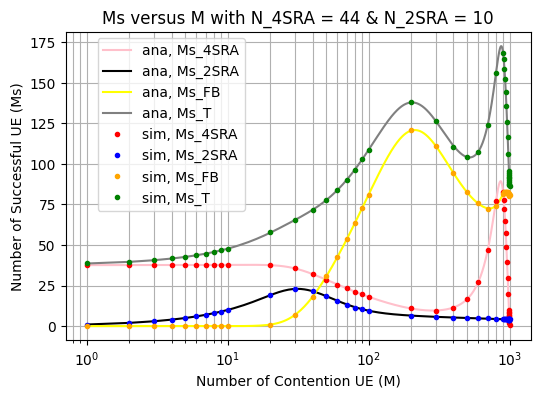

In [60]:
# Ms
plt.plot(ana.M_2SRA, ana.Ms_4SRA, '-', color = 'pink', label = 'ana, Ms_4SRA')
plt.plot(ana.M_2SRA, ana.Ms_2SRA, '-', color = 'black', label = 'ana, Ms_2SRA')
plt.plot(ana.M_2SRA, ana.Ms_FB, '-', color = 'yellow', label = 'ana, Ms_FB')
plt.plot(ana.M_2SRA, ana.Ms_T, '-', color = 'gray', label = 'ana, Ms_T')
plt.plot(sim.M_2SRA, sim.Ms_4SRA, 'o', ms = 3, color = 'red', label = 'sim, Ms_4SRA')
plt.plot(sim.M_2SRA, sim.Ms_2SRA, 'o', ms = 3, color = 'blue', label = 'sim, Ms_2SRA')
plt.plot(sim.M_2SRA, sim.Ms_FB, 'o', ms = 3, color = 'orange', label = 'sim, Ms_FB')
plt.plot(sim.M_2SRA, sim.Ms_T, 'o', ms = 3, color = 'green', label = 'sim, Ms_T')
plt.xscale('log')
plt.title('Ms versus M with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Number of Successful UE (Ms)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

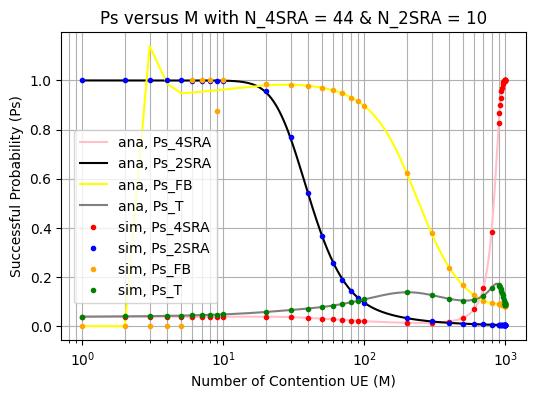

In [61]:
# Ps
plt.plot(ana.M_2SRA, ana.Ps_4SRA, '-', color = 'pink', label = 'ana, Ps_4SRA')
plt.plot(ana.M_2SRA, ana.Ps_2SRA, '-', color = 'black', label = 'ana, Ps_2SRA')
plt.plot(ana.M_2SRA, ana.Ps_FB, '-', color = 'yellow', label = 'ana, Ps_FB')
plt.plot(ana.M_2SRA, ana.Ps_T, '-', color = 'gray', label = 'ana, Ps_T')
plt.plot(sim.M_2SRA, sim.Ps_4SRA, 'o', ms = 3, color = 'red', label = 'sim, Ps_4SRA')
plt.plot(sim.M_2SRA, sim.Ps_2SRA, 'o', ms = 3, color = 'blue', label = 'sim, Ps_2SRA')
plt.plot(sim.M_2SRA, sim.Ps_FB, 'o', ms = 3, color = 'orange', label = 'sim, Ps_FB')
plt.plot(sim.M_2SRA, sim.Ps_T, 'o', ms = 3, color = 'green', label = 'sim, Ps_T')
plt.xscale('log')
plt.title('Ps versus M with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Successful Probability (Ps)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.35, 0.4))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

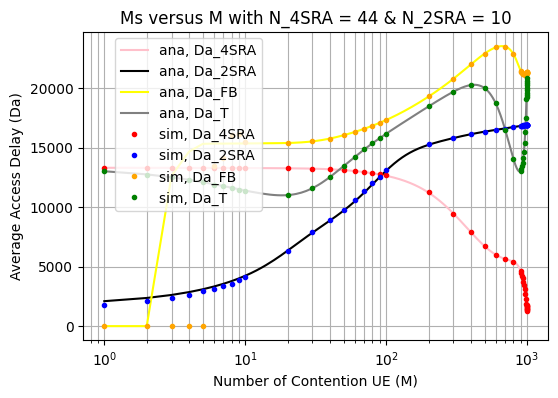

In [62]:
# Da
plt.plot(ana.M_2SRA, ana.Da_4SRA, '-', color = 'pink', label = 'ana, Da_4SRA')
plt.plot(ana.M_2SRA, ana.Da_2SRA, '-', color = 'black', label = 'ana, Da_2SRA')
plt.plot(ana.M_2SRA, ana.Da_FB, '-', color = 'yellow', label = 'ana, Da_FB')
plt.plot(ana.M_2SRA, ana.Da_T, '-', color = 'gray', label = 'ana, Da_T')
plt.plot(sim.M_2SRA, sim.Da_4SRA, 'o', ms = 3, color = 'red', label = 'sim, Da_4SRA')
plt.plot(sim.M_2SRA, sim.Da_2SRA, 'o', ms = 3, color = 'blue', label = 'sim, Da_2SRA')
plt.plot(sim.M_2SRA, sim.Da_FB, 'o', ms = 3, color = 'orange', label = 'sim, Da_FB')
plt.plot(sim.M_2SRA, sim.Da_T, 'o', ms = 3, color = 'green', label = 'sim, Da_T')
plt.xscale('log')
plt.title('Ms versus M with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Average Access Delay (Da)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.7))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

<ipython-input-63-aa5a32e6e9eb>:23: RuntimeWarning: invalid value encountered in double_scalars
  err_Ps_FB[m] = float((abs(sim.Ps_FB[m] - ana.Ps_FB[num_UE_2SRA[m] - 1]) / sim.Ps_FB[m]) * 100)
<ipython-input-63-aa5a32e6e9eb>:24: RuntimeWarning: invalid value encountered in double_scalars
  err_Da_FB[m] = float((abs(sim.Da_FB[m] - ana.Da_FB[num_UE_2SRA[m] - 1]) / sim.Da_FB[m]) * 100)
<ipython-input-63-aa5a32e6e9eb>:23: RuntimeWarning: divide by zero encountered in double_scalars
  err_Ps_FB[m] = float((abs(sim.Ps_FB[m] - ana.Ps_FB[num_UE_2SRA[m] - 1]) / sim.Ps_FB[m]) * 100)
<ipython-input-63-aa5a32e6e9eb>:24: RuntimeWarning: divide by zero encountered in double_scalars
  err_Da_FB[m] = float((abs(sim.Da_FB[m] - ana.Da_FB[num_UE_2SRA[m] - 1]) / sim.Da_FB[m]) * 100)


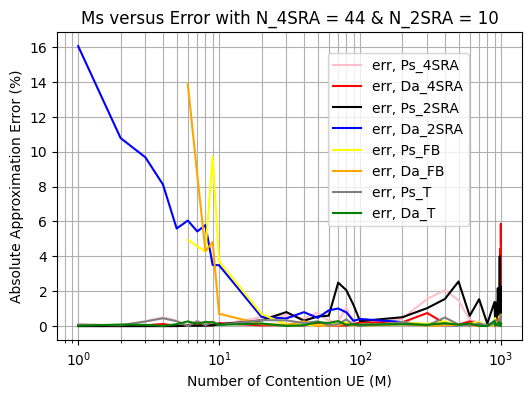

In [63]:
# Error rate
num_UE_2SRA = [1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90,
               100, 200, 300, 400, 500, 600, 700, 800, 900,
               910, 920, 930, 940, 950, 960, 970, 980, 990,
               991, 992, 993, 994, 995, 996, 997, 998, 999]

# err_Ms = [0.0 for i in range(0, len(num_UE))]
err_Ps_4SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_4SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Ps_2SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_2SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Ps_FB = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_FB = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Ps_T = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_T = [0.0 for i in range(0, len(num_UE_2SRA))]
for m in range(0, len(num_UE_2SRA)):
  # err_Ms[m] = float((abs(sim.Ms[m] - ana.Ms[num_UE[m] - 1]) / sim.Ms[m]) * 100)
  err_Ps_4SRA[m] = float((abs(sim.Ps_4SRA[m] - ana.Ps_4SRA[num_UE_2SRA[m] - 1]) / sim.Ps_4SRA[m]) * 100)
  err_Da_4SRA[m] = float((abs(sim.Da_4SRA[m] - ana.Da_4SRA[num_UE_2SRA[m] - 1]) / sim.Da_4SRA[m]) * 100)
  err_Ps_2SRA[m] = float((abs(sim.Ps_2SRA[m] - ana.Ps_2SRA[num_UE_2SRA[m] - 1]) / sim.Ps_2SRA[m]) * 100)
  err_Da_2SRA[m] = float((abs(sim.Da_2SRA[m] - ana.Da_2SRA[num_UE_2SRA[m] - 1]) / sim.Da_2SRA[m]) * 100)
  err_Ps_FB[m] = float((abs(sim.Ps_FB[m] - ana.Ps_FB[num_UE_2SRA[m] - 1]) / sim.Ps_FB[m]) * 100)
  err_Da_FB[m] = float((abs(sim.Da_FB[m] - ana.Da_FB[num_UE_2SRA[m] - 1]) / sim.Da_FB[m]) * 100)
  err_Ps_T[m] = float((abs(sim.Ps_T[m] - ana.Ps_T[num_UE_2SRA[m] - 1]) / sim.Ps_T[m]) * 100)
  err_Da_T[m] = float((abs(sim.Da_T[m] - ana.Da_T[num_UE_2SRA[m] - 1]) / sim.Da_T[m]) * 100)

# plt.plot(sim.M, err_Ms, '-', color = 'green', label = 'err, Ms')
plt.plot(sim.M_2SRA, err_Ps_4SRA, '-', color = 'pink', label = 'err, Ps_4SRA')
plt.plot(sim.M_2SRA, err_Da_4SRA, '-', color = 'red', label = 'err, Da_4SRA')
plt.plot(sim.M_2SRA, err_Ps_2SRA, '-', color = 'black', label = 'err, Ps_2SRA')
plt.plot(sim.M_2SRA, err_Da_2SRA, '-', color = 'blue', label = 'err, Da_2SRA')
plt.plot(sim.M_2SRA, err_Ps_FB, '-', color = 'yellow', label = 'err, Ps_FB')
plt.plot(sim.M_2SRA, err_Da_FB, '-', color = 'orange', label = 'err, Da_FB')
plt.plot(sim.M_2SRA, err_Ps_T, '-', color = 'gray', label = 'err, Ps_T')
plt.plot(sim.M_2SRA, err_Da_T, '-', color = 'green', label = 'err, Da_T')
plt.xscale('log')
plt.title('Ms versus Error with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Absolute Approximation Error (%)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.9, 0.65))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

## **Appendix A : Fallback UEs in different T_RAREP cases**


### **Case 1**

- **4SRA has same T_RAREP than 2SRA** (ex : 1280 = 1280)
 - Each 4SRA slot number will have fallback UEs from each 2SRA slot number
- **Methodology**
 - **Move all the failed UEs from 2SRA to 4SRA after each slot finishing**

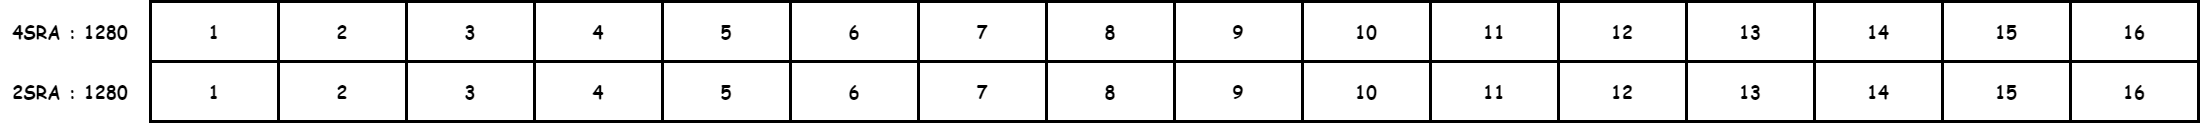

### **Case 2**

- **4SRA has larger T_RAREP than 2SRA** (ex : 1780 > 1280)
 - 2SRA slot 3 and 4 will have fallback UEs to 4SRA slot 3
 - 2SRA slot 7 and 8 will have fallback UEs to 4SRA slot 6
 - 2SRA slot 10 and 11 will have fallback UEs to 4SRA slot 8
 - 2SRA slot 14 and 15 will have fallback UEs to 4SRA slot 11
- **Methodology**
 - **Main concept is to check can 4SRA T_RAREP have more than one 2SRA T_RAREP?**
 - Because both 2SRA and 4SRA will do the process synchronously, so we need to check whether there could have multiple 2SRA slots within a 4SRA slot while the process goes
 - If we find that there could be multiple 2SRA slots in a 4SRA slot, we stop the 4SRA process, but 2SRA process still continues
 - After we find that 4SRA slot cannot include any one more 2SRA slot, we make 4SRA process go to next slot, while 2SRA process has already been to next few slot
- **Example**
 - The FOR LOOP goes to slot 3, but 4SRA slot 3 can include 2SRA slot 3 and next 2SRA slots, we don't make 4SRA slot goes from 3 to 4, but 2SRA slot goes from 3 to 4
 - Later, we find that 4SRA slot 3 cannot include one more 2SRA slot (which is 2SRA slot 5), so we make 4SRA slot go from 3 to 4, and 2SRA slot will go from 4 to 5 at this moment
 - From this exmaple, we know that 4SRA slot 3 could include 2SRA slot 3 and 4
- **Figure**
 - Red 2SRA slots : means they will have to fallback UEs with other red 2SRA slot
 - Yellow 4SRA slots : means they will have fallback UEs from multiple 2SRA slots

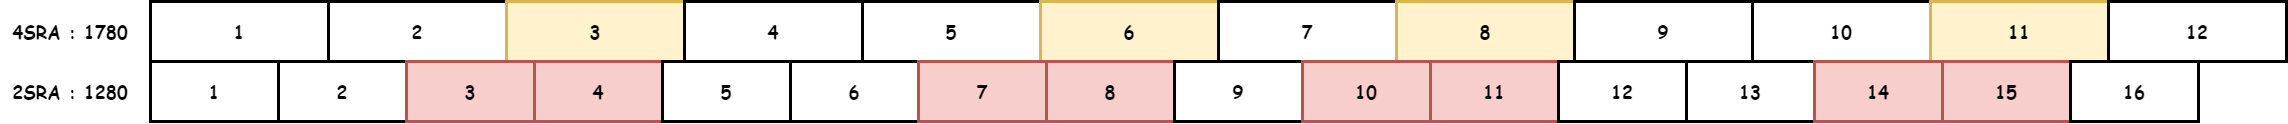

### **Case 3**

- **4SRA has smaller T_RAREP than 2SRA** (ex : 1280 < 1780)
 - 4SRA slot 1, 4, 8, 11, and 15 will have no fallback UEs from any 2SRA slots
- **Methodology**
 - **Main concept is to check current 2SRA slot is larger or smaller than current on-going 4SRA slot?**
 - Because both 2SRA and 4SRA will do the process synchronously, so we need to check whether 2SRA process will need to wait for 4SRA process
 - If we find that current 2SRA slot is larger then current on-going 4SRA slot, we stop the 2SRA process, but 4SRA process still continues
 - After we find that current on-going 4SRA slot is larger than current 2SRA slot, we make 2SRA process go to next slot, while 4SRA process has already been to next few slot
- **Note**
 - Actually, we cannot make 2SRA slot stops until it reaches to valid 4SRA slot, because cuurent 2SRA slot will have fallback UEs in the middle of 2SRA slot, no at the end of 2SRA slot
 - But here we assume that fallback UEs from 2SRA will only do the fallback at end of 2SRA slot, this assumption will cause some analysis error
 - This assumption is important, or it is really difficult to implement the simulation (how could we fallback UEs in the middle the slot of a FOR LOOP???)
- **Example**
 - The FOR LOOP goes to slot 1, but 2SRA slot 1 is larger than 4SRA slot 1, we don't make 2SRA slot goes from 1 to 2, but 4SRA slot goes from 1 to 2
 - Later, we find that 2SRA slot 1 is smaller than current 4SRA slot (which is 4SRA slot 2), so we make 2SRA slot go from 1 to 2, and 4SRA slot will go from 2 to 3 at this moment
 - From this exmaple, we know that 2SRA slot 1 has fallback UEs to 4SRA slot 2 but not 4SRA slot 1
- **Figure**
 - Blue 4SRA slots : means they will have no fallback UEs from 2SRA slot

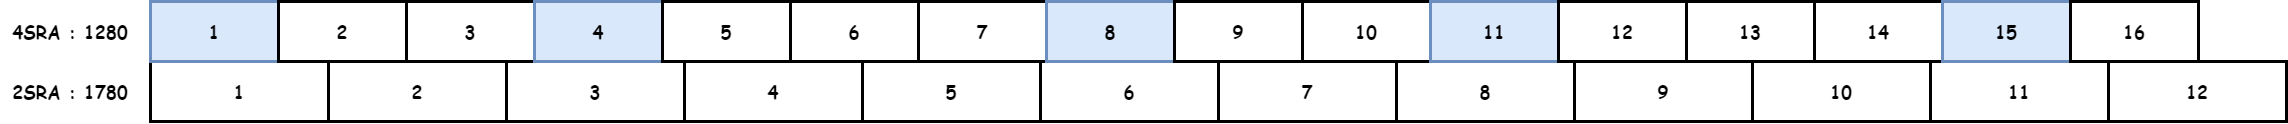